# GNNモデルを解釈する

目的：訓練済みのGNNモデルを解釈する   
モデル：GNNExplainer   
開発環境: python 3.11.5/ JupyterLab 3.6.3/Jupyter Notebook Version: 6.5.4/System: Linux #14~22.04.1-Ubuntu SMP PREEMPT_DYNAMIC

In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F

from torch_geometric.data import Data
from torch_geometric.nn import GCNConv
from torch_geometric.loader import DataLoader
from torch_geometric.nn.pool import global_mean_pool
from torch_geometric.explain import Explainer, GNNExplainer, ModelConfig

import numpy as np
import pandas as pd

from tslearn.metrics import dtw
from sklearn.metrics import precision_score, recall_score, roc_auc_score, average_precision_score, f1_score, accuracy_score
from tqdm.auto import tqdm

Pandas version: 2.0.3   
Numpy version: 1.24.3   
sklearn: 1.3.0   
sklearn: 0.6.3   
torch: 2.1.1   
torch_geometric: 2.4.0   
tqdm: 4.65.0

In [5]:
# Load datasets
'''
9 currency pairs from 2018-01-01 18:10:00 to 2023-11-17 16:10:00
'''

def load_dataset(filename, start_date, end_date):
    
    df = pd.read_csv(f'processed_data/{filename}.csv',sep = ',')
    df.set_index('Times', inplace=True)
    
    df = df.loc[start_date:end_date]
    df.reset_index(inplace=True)
    
    return df

start_date = '2021-06-01 18:10:00'
end_date = '2023-11-17 16:10:00'

variable_names = ["usdjpy","cadjpy","audjpy","eurjpy","zarjpy","sgdjpy","nzdjpy","gbpjpy","chfjpy"]
for name in variable_names:
    exec(f"{name} = load_dataset(str.upper('{name}'), start_date, end_date)")
    exec(f"display({name}.head())")

,Times,Final Price,Final Price Normalized,1h_Return,Label,Currency
0,2021-06-01 18:10:00,109.480,0.163151,-0.000082,0,0
1,2021-06-01 18:11:00,109.486,0.163269,-0.000064,0,0
2,2021-06-01 18:12:00,109.486,0.163269,-0.000018,0,0
3,2021-06-01 18:13:00,109.487,0.163289,0.000037,1,0
4,2021-06-01 18:14:00,109.489,0.163328,0.000059,1,0


,Times,Final Price,Final Price Normalized,1h_Return,Label,Currency
0,2021-06-01 18:10:00,90.657,0.450249,-0.000132,0,1
1,2021-06-01 18:11:00,90.662,0.450384,-0.000055,0,1
2,2021-06-01 18:12:00,90.662,0.450384,-0.000099,0,1
3,2021-06-01 18:13:00,90.662,0.450384,-0.000143,0,1
4,2021-06-01 18:14:00,90.662,0.450384,-0.000110,0,1


,Times,Final Price,Final Price Normalized,1h_Return,Label,Currency
0,2021-06-01 18:10:00,84.859,0.644397,-0.000177,0,2
1,2021-06-01 18:11:00,84.859,0.644397,-0.000224,0,2
2,2021-06-01 18:12:00,84.867,0.644605,0.000141,1,2
3,2021-06-01 18:13:00,84.865,0.644553,0.000236,1,2
4,2021-06-01 18:14:00,84.865,0.644553,0.000471,1,2


,Times,Final Price,Final Price Normalized,1h_Return,Label,Currency
0,2021-06-01 18:10:00,133.701,0.386427,-0.000165,0,3
1,2021-06-01 18:11:00,133.707,0.386547,-0.000187,0,3
2,2021-06-01 18:12:00,133.705,0.386507,-0.000202,0,3
3,2021-06-01 18:13:00,133.709,0.386587,-0.000299,0,3
4,2021-06-01 18:14:00,133.713,0.386668,-0.000247,0,3


,Times,Final Price,Final Price Normalized,1h_Return,Label,Currency
0,2021-06-01 18:10:00,7.95375,0.642117,0.001514,1,4
1,2021-06-01 18:11:00,7.95350,0.642050,0.001519,1,4
2,2021-06-01 18:12:00,7.95325,0.641983,0.001523,1,4
3,2021-06-01 18:13:00,7.95300,0.641916,0.001528,1,4
4,2021-06-01 18:14:00,7.95300,0.641916,0.001564,1,4


,Times,Final Price,Final Price Normalized,1h_Return,Label,Currency
0,2021-06-01 18:10:00,82.743,0.244948,-0.000024,0,5
1,2021-06-01 18:11:00,82.740,0.244871,-0.000060,0,5
2,2021-06-01 18:12:00,82.741,0.244897,0.000157,1,5
3,2021-06-01 18:13:00,82.747,0.245051,0.000242,1,5
4,2021-06-01 18:14:00,82.747,0.245051,0.000520,1,5


,Times,Final Price,Final Price Normalized,1h_Return,Label,Currency
0,2021-06-01 18:10:00,79.384,0.625907,-0.000042,0,6
1,2021-06-01 18:11:00,79.389,0.626065,0.000038,1,6
2,2021-06-01 18:12:00,79.406,0.626604,0.000252,1,6
3,2021-06-01 18:13:00,79.400,0.626414,0.000176,1,6
4,2021-06-01 18:14:00,79.401,0.626446,0.000202,1,6


,Times,Final Price,Final Price Normalized,1h_Return,Label,Currency
0,2021-06-01 18:10:00,154.878,0.475557,-0.000039,0,7
1,2021-06-01 18:11:00,154.887,0.475697,-0.000194,0,7
2,2021-06-01 18:12:00,154.885,0.475666,-0.000161,0,7
3,2021-06-01 18:13:00,154.886,0.475682,-0.000168,0,7
4,2021-06-01 18:14:00,154.892,0.475775,-0.000110,0,7


,Times,Final Price,Final Price Normalized,1h_Return,Label,Currency
0,2021-06-01 18:10:00,121.983,0.244831,-0.000697,0,8
1,2021-06-01 18:11:00,121.988,0.244908,-0.000434,0,8
2,2021-06-01 18:12:00,121.989,0.244924,-0.000484,0,8
3,2021-06-01 18:13:00,121.988,0.244908,-0.000541,0,8
4,2021-06-01 18:14:00,121.992,0.244971,-0.000434,0,8


In [6]:
# Combine all the datasets
combined_df = pd.concat([usdjpy, cadjpy, audjpy, eurjpy, zarjpy, sgdjpy, nzdjpy, gbpjpy, chfjpy], axis=1)
display(combined_df.head())

# combined_df.shape

,Times,Final Price,Final Price Normalized,1h_Return,Label,Currency,Times,Final Price,Final Price Normalized,1h_Return,...,Final Price Normalized,1h_Return,Label,Currency,Times,Final Price,Final Price Normalized,1h_Return,Label,Currency
0,2021-06-01 18:10:00,109.480,0.163151,-0.000082,0,0,2021-06-01 18:10:00,90.657,0.450249,-0.000132,...,0.475557,-0.000039,0,7,2021-06-01 18:10:00,121.983,0.244831,-0.000697,0,8
1,2021-06-01 18:11:00,109.486,0.163269,-0.000064,0,0,2021-06-01 18:11:00,90.662,0.450384,-0.000055,...,0.475697,-0.000194,0,7,2021-06-01 18:11:00,121.988,0.244908,-0.000434,0,8
2,2021-06-01 18:12:00,109.486,0.163269,-0.000018,0,0,2021-06-01 18:12:00,90.662,0.450384,-0.000099,...,0.475666,-0.000161,0,7,2021-06-01 18:12:00,121.989,0.244924,-0.000484,0,8
3,2021-06-01 18:13:00,109.487,0.163289,0.000037,1,0,2021-06-01 18:13:00,90.662,0.450384,-0.000143,...,0.475682,-0.000168,0,7,2021-06-01 18:13:00,121.988,0.244908,-0.000541,0,8
4,2021-06-01 18:14:00,109.489,0.163328,0.000059,1,0,2021-06-01 18:14:00,90.662,0.450384,-0.000110,...,0.475775,-0.000110,0,7,2021-06-01 18:14:00,121.992,0.244971,-0.000434,0,8


In [47]:
# Function to compute technical indicator
'''
Calculates each technical indicator using the entire hour for each node.
'''

# Calculate Bollinger Bands for the entire hour
def calculate_bollinger_bands(data):
    window = len(data)
    rolling_mean = data.rolling(window=window).mean()
    upper_band = rolling_mean + 2 * data.rolling(window=window).std()
    lower_band = rolling_mean - 2 * data.rolling(window=window).std()
    
    return upper_band.iloc[-1], lower_band.iloc[-1], rolling_mean.iloc[-1]

# Calculate RSI for the entire hour
def calculate_rsi(data):
    diff = data.diff(1).dropna()
    gain = diff.where(diff > 0, 0)
    loss = -diff.where(diff < 0, 0)

    avg_gain = gain.mean()
    avg_loss = loss.mean()

    if avg_loss == 0:
        rs = np.inf  # Set to infinity to avoid division by zero
    else:
        rs = avg_gain / avg_loss

    rsi = 100 - (100 / (1 + rs))
    return rsi

# Calculate RCI for the entire hour
def calculate_rci(data):
    rci = data.pct_change().sum()
    return rci

# Calculate Momentum for the entire hour
def calculate_momentum(data, n=59):
    return data.diff(n).iloc[-1]

In [49]:
# Function to create a single graph (snapshot)

'''
In each graph we use data within 18 hours.
Each hour each currency pair forms a node, so each snapshot contains 18*9　nodes.
Weighted edges are generated from computing DTW of two nodes (two 1 hour series) using "Final Price Normalized"
Node features consist of "Final Price Normalized", "1h_Return", "Currency"　and technical indicator
'''

def create_graph(snapshot, node_window=60, node_stride=60):
    
    features = snapshot[[ 'Final Price Normalized','1h_Return', 'Currency', 'Final Price']].values
    
    series = []
    currencies = []
    prices = []
    h_returns = []
    Final_prices = []
    volatilities = []
    
    upper_bands = []
    lower_bands = []
    rolling_means = []
    rsis = []
    rcis = []
    momenta = []  
    
     
    for i in range(0, len(snapshot) - node_window + 1, node_stride):
        for j in range (2): 
            serie = features[i:i+node_window,j]
            series.append(serie) 
            

            currency = features[i+node_window-1,j+4]
            currencies.append(currency)

            price = features[i+node_window-1, j]
            prices.append(price)
            
            Final_price = features[i:i+node_window, j+6]
            Final_prices.append(Final_price)

            h_return = features[i+node_window-1, j+2]
            h_returns.append(h_return)
            
            # Create a DataFrame with the stock price data
            df = pd.DataFrame({'Close': Final_price})

            # Calculate Bollinger Bands
            upper_band, lower_band, mean = calculate_bollinger_bands(df['Close'])
            upper_bands.append(upper_band)
            lower_bands.append(lower_band)
            rolling_means.append(mean)

            # Calculate RSI for the entire hour using the function
            rsi = calculate_rsi(df['Close'])
            rsis.append(rsi)

            # Calculate RCI for the entire hour using the function
            rci = calculate_rci(df['Close'])
            rcis.append(rci)
            
            # Calculate Momentum for the entire hour using the function
            momentum = calculate_momentum(df['Close'])
            momenta.append(momentum)
            
            all_return = features[i:i+node_window, j+2]
            
            # Create a DataFrame with the returns
            df_r = pd.DataFrame({'Return': all_return})
            # Compute volatility (standard deviation of returns)
            volatility = df_r['Return'].std()
            volatilities.append(volatility)
            
    # Edge generation 
    adjacency_matrix = np.zeros((len(series), len(series)))
    threshold = 0.85
    
    for i in range(len(series)):
        for j in range(i+1, len(series)):
            dtw_distance = dtw(series[i], series[j])

            # Update the maximum observed DTW distance dynamically
            max_dtw_distance = max(max_dtw_distance, dtw_distance) if 'max_dtw_distance' in locals() else dtw_distance
    
    for i in range(len(series)):
        for j in range(i+1, len(series)):
            dtw_distance = dtw(series[i], series[j])
            similarity = 1 - (dtw_distance / max_dtw_distance)

            # adjacency_matrix[i, j] = similarity
            # adjacency_matrix[j, i] = similarity            
            # Apply the threshold to convert to 0 or 1
            if similarity > threshold:
                adjacency_matrix[i, j] = 1
                adjacency_matrix[j, i] = 1
            else:
                adjacency_matrix[i, j] = 0
                adjacency_matrix[j, i] = 0

    np.fill_diagonal(adjacency_matrix, 1)
    # print(adjacency_matrix.shape)

    feature_matrix = np.transpose(np.vstack((prices, h_returns, currencies, upper_bands, lower_bands, rolling_means, rsis, rcis, momenta, volatilities)))

    return adjacency_matrix, feature_matrix


In [50]:
# Function to create graphs
'''
Build a graph using 18 hours of data, then move forward by 1 hour and build the next graph using the next 18 hours of data,
store them in a list graphs.
Time window of each graph is 18*60, stride is 60.

The label of each graph is the 'Lable' of the next hour's data, ("Label" is 1 if "1h_return" is larger than 1, 0 otherwise)
Because we want to use each graph(18 hours data) to predict the next hour data.
The label of each graph is a sequence of 9 binary values, each represents a currency.
'''

def create_graphs(data, time_window=18*60, stride=60):
    adjacency_matrice = []
    feature_matrice = []
    graphs = []
    labels = []
    
    # Get label data
    Label = data['Label'].values
    
    # Iterate through data with a sliding window
    for i in tqdm(range(0, len(data) - 2*time_window + 1, stride)):
    # Get a snapshot of the time series data
        snapshot = data.iloc[i:i + time_window]
        
        # Generate adjacency matrix and feature matrix from the snapshot
        adjacency_matrix, feature_matrix = create_graph(snapshot)
        
        # Get the label
        label = labels_data[i + time_window + 61]
        
        # Create edge index indicating positions of non-zero elements
        edge_index = torch.tensor([[i, j] for i in range(adjacency_matrix.shape[0]) for j in range(adjacency_matrix.shape[1]) if adjacency_matrix[i, j] != 0], dtype=torch.long).t().contiguous()
        
        # Convert to PyTorch Tensors
        x_tensor = torch.FloatTensor(feature_matrix)
        y_tensor = torch.LongTensor(label)       

        # Create a PyTorch Geometric Data object
        graph = Data(x=x_tensor, edge_index=edge_index)
        
        # Append to the lists
        graphs.append(graph)
        labels.append(y_tensor)

    return graphs, labels


In [51]:
#GCN
'''
The task is graph classification.
Output is the label of each graph which is a sequence of 9 binary values, each represents a currency.
'''

class GCNModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(GCNModel, self).__init__()
        self.conv1 = GCNConv(input_dim, hidden_dim)
        self.conv2 = GCNConv(hidden_dim, hidden_dim)
        self.linear1 = nn.Linear(hidden_dim, output_dim)

    def forward(self, data):
        x, edge_index, batch = data.x, data.edge_index, data.batch

        x = F.relu(self.conv1(x, edge_index))
        x = self.conv2(x, edge_index)
        
        # Readout layer, take feature-wise average values of all node embeddings and use it as a graph feature of an input graph 
        x = global_mean_pool(x, batch)
        
        # Transform a graph feature by a linear transformation
        x= self.linear1(x)
        
        #Employ a sigmoid function as an activation function of the output layer
        x = torch.sigmoid(x)
        return x

In [52]:
# Generate all snapshots. 
graphs, labels = create_graphs(combined_df)

  0%|          | 0/21539 [00:00<?, ?it/s]

In [26]:
# Split data into training and testing sets
split_ratio = 0.85
split_idx = int(split_ratio * len(graphs))

train_data = graphs[:split_idx]
train_labels = labels[:split_idx]


test_data = graphs[split_idx:]
test_labels = labels[split_idx:]


In [27]:
# Set batch size for training
batch_size = 1

# Learning rate for optimization
lr = 0.00006

# Create DataLoader for training and test data with specified batch size and shuffle
train_loader = DataLoader(list(zip(train_data, train_labels)), batch_size=batch_size, shuffle=False)
test_loader = DataLoader(list(zip(test_data, test_labels)), batch_size=batch_size, shuffle=False)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = GCNModel(input_dim=10, hidden_dim=80, output_dim=1).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
criterion = nn.BCELoss()

In [28]:
# Training loop 
num_epochs = 1500
for epoch in range(num_epochs):
    model.train()
    for batch in train_loader:
        graphs, labels = batch
        graphs = graphs.to(device)
        labels = labels.to(device)
        labels = labels.float()
        optimizer.zero_grad()
        
        x, edge_index = graphs.x, graphs.edge_index
        output = model(x, edge_index)
        output = output.float()
        
        # print(output.shape)
        # print(labels.shape)
        loss = criterion(output, labels)
        loss.backward()
        optimizer.step()
    if (epoch + 1) % 50 == 0:
        print(f'Epoch:{epoch + 1} \t loss: {loss:.6f}')
        torch.save(model.state_dict(), 'GCN_2pairs_ti.dat')


Epoch:50 	 loss: 0.652752
Epoch:100 	 loss: 0.685080
Epoch:150 	 loss: 0.684123


Generated explanations in ['edge_mask', 'node_mask']


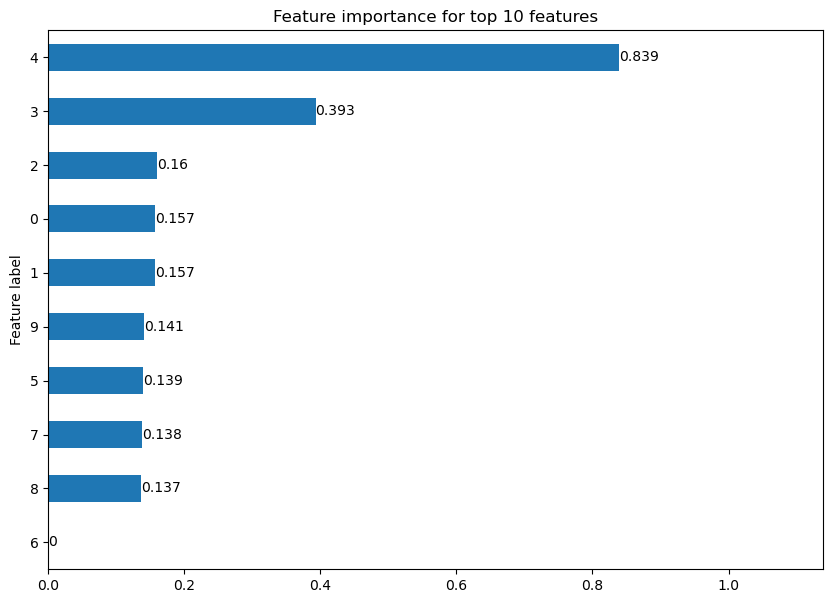

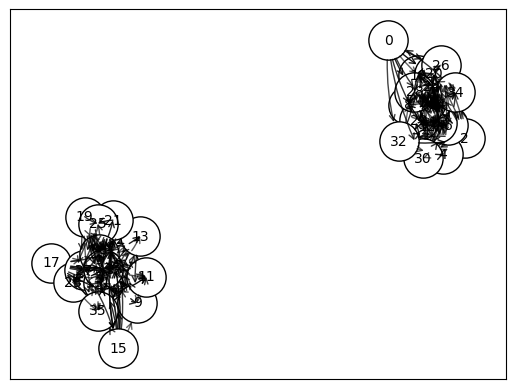

Subgraph visualization plot has been saved to 'subgraph.pdf'


In [43]:
# Iterate through batches in the test loader
for batch in test_loader:
    # Unpack the batch into graphs_batch and labels_batch
    graphs_batch, labels_batch = batch
    
    # Choose the first graph from the batch for explanation
    graph_to_explain = graphs_batch[0].to(device)
    
    # Extract node features and edge indices from the chosen graph
    x, edge_index = graph_to_explain.x, graph_to_explain.edge_index
    
    # Move labels to the selected device
    labels_batch = labels_batch.to(device)
    
    # Set the model to evaluation mode
    model.eval()

    # Create an Explainer instance with GNNExplainer algorithm
    explainer = Explainer(
        model=model,
        algorithm=GNNExplainer(epochs=200),
        explanation_type='model',
        node_mask_type='common_attributes',
        edge_mask_type='object',
        model_config=dict(
            mode='binary_classification',
            task_level='graph',
            return_type='probs',
        ),
    )
    
    # Generate explanation for the chosen graph
    explanation = explainer(graph_to_explain.x, graph_to_explain.edge_index)

    # Print available explanations
    print(f'Generated explanations in {explanation.available_explanations}')

    # Visualize feature importance and save the plot
    path = 'feature_importance.png'
    explanation.visualize_feature_importance(top_k=10)
    
    # Visualize the subgraph and save the plot
    path = 'subgraph.pdf'
    explanation.visualize_graph()

    # Break the loop after processing the first batch
    break

## Node feature:
0. prices
1. h_returns
2. currencies
3. upper_bands
4. lower_bands
5. rolling_means
6. rsis
7. rcis
8. momenta
9. volatilities